In [1]:
import tensorflow as tf
from sklearn.metrics import mean_squared_error, euclidean_distances, median_absolute_error
import numpy as np
import pandas as pd
from astroNN.nn.layers import MCDropout
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import scipy.integrate as intg
from scipy.misc import derivative
from scipy.integrate import quad
import seaborn as sns
from scipy.interpolate import interp1d
from statsmodels.nonparametric.smoothers_lowess import lowess

2024-02-12 01:16:31.586547: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-12 01:16:31.588988: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-12 01:16:31.626251: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-12 01:16:31.626278: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-12 01:16:31.627247: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
def get_smoothed_curve(z_or, prediction, sigma, curve_type='lower', frac=0.05):
    """
    Get the smoothed curve based on the provided data and curve type.

    Parameters:
    - z_or: Original x-values.
    - prediction: Central prediction values.
    - sigma: Error values.
    - curve_type: String, either 'upper' or 'lower'. Specifies which curve to return.
    - frac: Fraction for lowess smoothing.

    Returns:
    - smoothed_curve: Array with two columns, the first being x-values and the second being y-values of the smoothed curve.
    """
    if curve_type == 'lower':
        prediction_curve = prediction - sigma
    elif curve_type == 'upper':
        prediction_curve = prediction + sigma
    else:
        raise ValueError("curve_type must be either 'upper' or 'lower'")

    f = interp1d(z_or.flatten(), prediction_curve)

    new_z_or = np.linspace(min(z_or.flatten()), max(z_or.flatten()), 100)
    interpolated_values = f(new_z_or)
    smoothed_curve = lowess(interpolated_values, new_z_or.ravel(), frac=frac)

    return smoothed_curve



# Large data set

In [3]:
model = tf.keras.models.load_model('models/large_lsst_model.h5', custom_objects={'MCDropout': MCDropout})

2024-02-12 01:16:33.696717: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-12 01:16:33.697105: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [4]:
data_folder = 'Data_SNIa_LSST/larger/'
df_data = pd.read_csv(data_folder+'hubble_diagram.txt', skiprows=5, sep=' ')
# Np = len(dfp.values)
# N s=  len(dfs.values)
df_data.head()

,CID,IDSURVEY,zCMB,zHEL,MU,MUERR,MUERR_VPEC,MUERR_SYS
0,SN:2521,50,0.01988,0.01988,34.84680,0.1320,0.0736,0.00796
1,SN:57482,50,0.02321,0.02321,34.89863,0.1551,0.0631,0.00720
2,SN:52921,50,0.02364,0.02364,35.28915,0.1243,0.0620,0.00771
3,SN:21365,50,0.02470,0.02470,35.11988,0.1444,0.0594,0.00717
4,SN:117311,50,0.02471,0.02471,35.19347,0.1232,0.0593,0.00702


In [5]:
df_data['errors'] = df_data['MUERR'].values+df_data['MUERR_SYS'].values
df_data.head()

,CID,IDSURVEY,zCMB,zHEL,MU,MUERR,MUERR_VPEC,MUERR_SYS,errors
0,SN:2521,50,0.01988,0.01988,34.84680,0.1320,0.0736,0.00796,0.13996
1,SN:57482,50,0.02321,0.02321,34.89863,0.1551,0.0631,0.00720,0.16230
2,SN:52921,50,0.02364,0.02364,35.28915,0.1243,0.0620,0.00771,0.13201
3,SN:21365,50,0.02470,0.02470,35.11988,0.1444,0.0594,0.00717,0.15157
4,SN:117311,50,0.02471,0.02471,35.19347,0.1232,0.0593,0.00702,0.13022


In [6]:
df_data = df_data[['zCMB', 'MU', 'errors']]

In [7]:
z_or = df_data[['zCMB']].values
y = df_data[['MU', 'errors']].values
zmin, zmax = np.min(z_or), np.max(z_or)


In [8]:
scalerz = StandardScaler()
scalerz.fit(z_or.reshape(-1,1))
# apply transform
z = scalerz.transform(z_or.reshape(-1,1))

In [9]:
# Generate test data
# test_batch_size = 500
test_batch_size = len(z)
x_test = z

mc_dropout_num = 100 # Run Dropout 100 times
predictions = np.zeros((mc_dropout_num, test_batch_size, 2))
uncertainty = np.zeros((mc_dropout_num, test_batch_size, 1))
for i in range(mc_dropout_num):
    predictions[i] = model.predict(scalerz.transform(z_or.reshape(-1,1)))
#     predictions[i] = model.predict(scalerz.transform(x_test.reshape(-1,1)))
    
# get mean results and its varience
prediction_mc_dropout = np.mean(predictions, axis=0)
std_mc_dropout = np.std(predictions, axis=0)


181/181 [==============================] - 0s 2ms/step


For lsst_large with LCDM:

- Om: 0.3163 +/- 0.0049
- h: 0.6967 +/- 0.1732

For lsst and CPL:

- Om: 0.3297 ± 0.0700
- h: 0.7125 ± 0.1585
- ω0: −1.0168 ± 0.0679
- ωa −0.4305 ± 0.8789


In [10]:
def RHSquared_a_owacdm(a, w0, wa, Om):
    rhow = a**(-3*(1.0+w0+wa))*np.exp(-3*wa*(1-a))
    return (Om/a**3+(1.0-Om)*rhow)

def DistIntegrand_a(a, w0, wa, Om):
        return 1./np.sqrt(RHSquared_a_owacdm(a, w0, wa, Om))/a**2
    
def Da_z(z, w0, wa, Om):
        r = intg.quad(DistIntegrand_a, 1./(1+z), 1, args=(w0, wa, Om))
        r = r[0]
        return r

### Hay que revisar esta constante en el return
def distance_modulus(z, w0=-1, wa=0.0, Om=0.23):
    return 5*np.log10(Da_z(z, w0, wa, Om)*(1+z))+24
# +43

# zmodel = np.linspace(0.01, 2.4, 100)
zmodel = z_or
flcdm = []
fcpl = []
# fowacdm2 = []
# fowacdm3 = []

for zzz in zmodel:
    flcdm.append(distance_modulus(zzz, w0=-1, wa=-0.0, Om=0.3163)+19)
    fcpl.append(distance_modulus(zzz, w0=-1.0168, wa=-0.4305, Om=0.3297)+19)


# Om: 0.3297 +/- 0.0700
# Obh2: 0.0220 +/- 0.0004
# h: 0.7125 +/- 0.1585
# w: -1.0168 +/- 0.0679
# wa: -0.4305 +/- 0.8789

In [11]:
len(prediction_mc_dropout[:,0]), len(x_test), len(zmodel)

(5785, 5785, 5785)

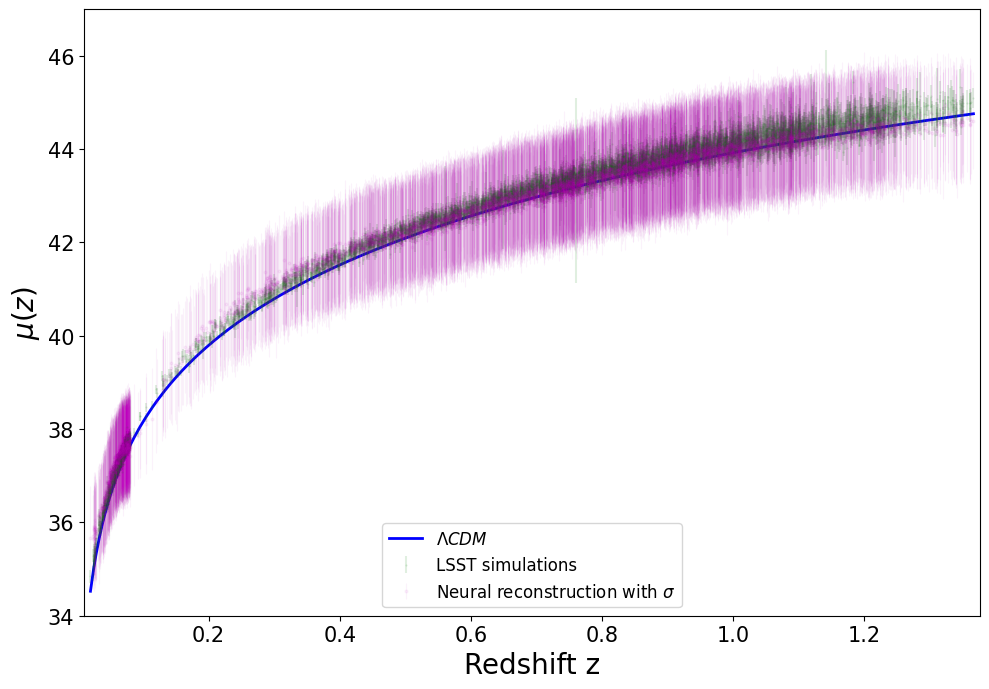

In [12]:
# plt.figure(figsize=(5, 4), dpi=100)
sigma = np.sqrt(std_mc_dropout[:, 0]**2 + std_mc_dropout[:, 1]**2+ prediction_mc_dropout[:,1]**2)

plt.figure(figsize=(10, 7), dpi=100)
# plt.scatter(scalerz.inverse_transform(zz), yy, color='k', label='Original cosmic chronometers')
plt.plot(zmodel, flcdm, label='$\Lambda CDM$', c='b', linewidth=2)
plt.errorbar(df_data['zCMB'], df_data['MU'], df_data['errors'], fmt='g.', markersize=1, alpha=0.12, label='LSST simulations')
plt.errorbar(z_or, prediction_mc_dropout[:,0], yerr=sigma, markersize=2, fmt='o', 
             ecolor='m', capthick=2, elinewidth=0.8, alpha=0.05, c='m',
             label='Neural reconstruction with $\sigma$')

plt.xlim(zmin-0.01,zmax+0.01)
plt.ylim(34, 47)

# plt.xlabel('Redshift')
# plt.ylabel('$H(z)$')
plt.xlabel("Redshift z", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.xscale('log')
plt.ylabel("$\mu(z)$", fontsize=20)
# plt.legend(loc='best')
plt.legend(fontsize=12, loc='lower center')
# plt.show()
plt.tight_layout()
plt.savefig('neural_rec_large.png', dpi=100)

## Comparing with Pantheon + and Pantheon old

In [13]:
# file = '/home/isidro/Documents/github/SNIa_ML_regressions/data/pantheon.txt'
file1 = 'https://raw.githubusercontent.com/igomezv/SNIa_ML_regressions/main/data/pantheon.txt'
syscov_file1 = 'https://raw.githubusercontent.com/igomezv/SNIa_ML_regressions/main/data/pantheon_errors.txt'
# file = 'data/lcparam_full_long.txt'
df1 = pd.read_csv(file1, sep = " ", usecols=['zcmb', 'mb', 'dmb'])
# df = pd.read_csv(file, sep = " ")
dmag1 = df1[['dmb']]
df1 = df1[['zcmb', 'mb']]
N = len(df1.values)
syscov1 = np.loadtxt(syscov_file1, skiprows=1).reshape((N, N))
cov1 = np.copy(syscov1)
sq_errors1 = np.diag(syscov1)
# df['errors'] = np.sqrt(sq_errors+dmag**2)
df1['errors'] = np.sqrt(sq_errors1)
df1.describe()

,zcmb,mb,errors
count,1048.000000,1048.000000,1048.000000
mean,0.322365,20.747108,0.012616
std,0.285995,2.647864,0.007511
min,0.010120,13.907450,0.005928
25%,0.131935,19.607525,0.007459
50%,0.248800,21.159450,0.010240
75%,0.422957,22.479637,0.014955
max,2.260000,26.877000,0.060238


In [14]:
file = 'https://raw.githubusercontent.com/igomezv/SNIa_ML_regressions/main/data/pantheon%2B_lcparam_full_long_zhel.txt'
syscov_file = 'https://raw.githubusercontent.com/igomezv/SNIa_ML_regressions/main/data/pantheon%2B_sys_full_long.txt'
# file = 'data/lcparam_full_long.txt'
df = pd.read_csv(file, sep = " ")
# df = pd.read_csv(file, sep = " ")
N = len(df.values)
syscov = np.loadtxt(syscov_file, skiprows=1).reshape((N, N))
cov = np.copy(syscov)
sq_errors = np.diag(syscov)
# df['errors'] = np.sqrt(sq_errors+dmag**2)
df['errors'] = np.sqrt(sq_errors)
# df['mb'] += 19.36
df = df[['zHD','m_b_corr','errors']]
df.head()

,zHD,m_b_corr,errors
0,0.00122,9.74571,0.178244
1,0.00122,9.80286,0.185921
2,0.00256,11.47030,0.247502
3,0.00256,11.49190,0.276550
4,0.00299,11.52270,0.625326


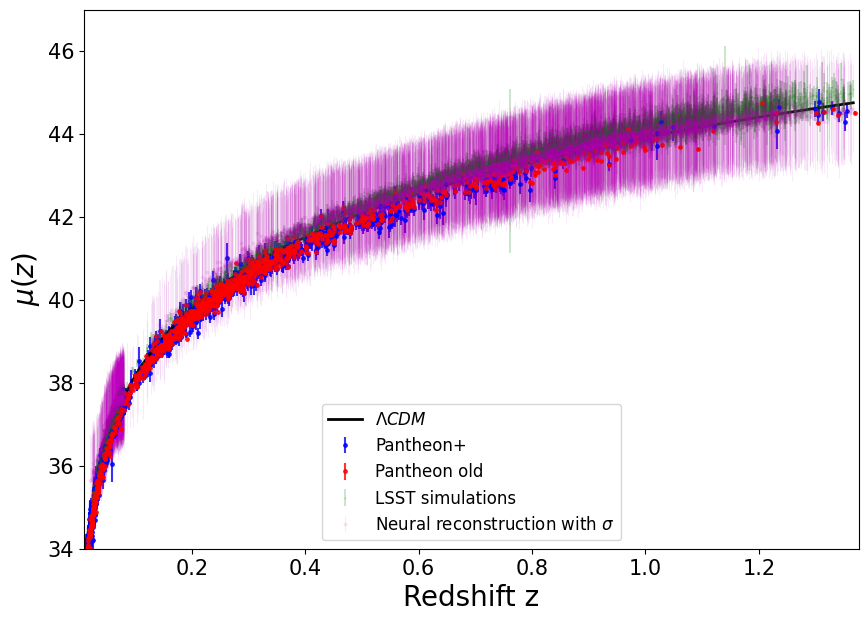

In [15]:
plt.figure(figsize=(10, 7), dpi=100)

plt.errorbar(df['zHD'], df['m_b_corr']+19, df['errors'], fmt='b.', markersize=5, label='Pantheon+', alpha=0.8)
plt.errorbar(df1['zcmb'], df1['mb']+19, df1['errors'], fmt='r.', markersize=5, label='Pantheon old', alpha=0.8)
# plt.scatter(scalerz.inverse_transform(zz), yy, color='k', label='Original cosmic chronometers')
plt.plot(zmodel, flcdm, label='$\Lambda CDM$', c='black', linewidth=2)
plt.errorbar(df_data['zCMB'], df_data['MU'], df_data['errors'], fmt='g.', markersize=1, alpha=0.2, label='LSST simulations')
plt.errorbar(z_or, prediction_mc_dropout[:,0], yerr=sigma, markersize=2, fmt='o', 
             ecolor='m', capthick=2, elinewidth=0.8, alpha=0.08, c='m',
             label='Neural reconstruction with $\sigma$')


plt.xlabel("Redshift z", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.xscale('log')


plt.ylabel("$\mu(z)$", fontsize=20)

plt.xlim(zmin-0.01,zmax+0.01)
plt.ylim(34, 47)

plt.legend(fontsize=12, loc='lower center')
plt.savefig('comparison_with_pantheon.png', dpi=100)

/tmp/ipykernel_73952/3962744670.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g." (-> color='g'). The keyword argument will take precedence.
  a2.errorbar(df_data['zCMB'], df_data['MU']-19, df_data['errors'], fmt='g.', markersize=4, color='g',
/tmp/ipykernel_73952/3962744670.py:44: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in legend.legendHandles:


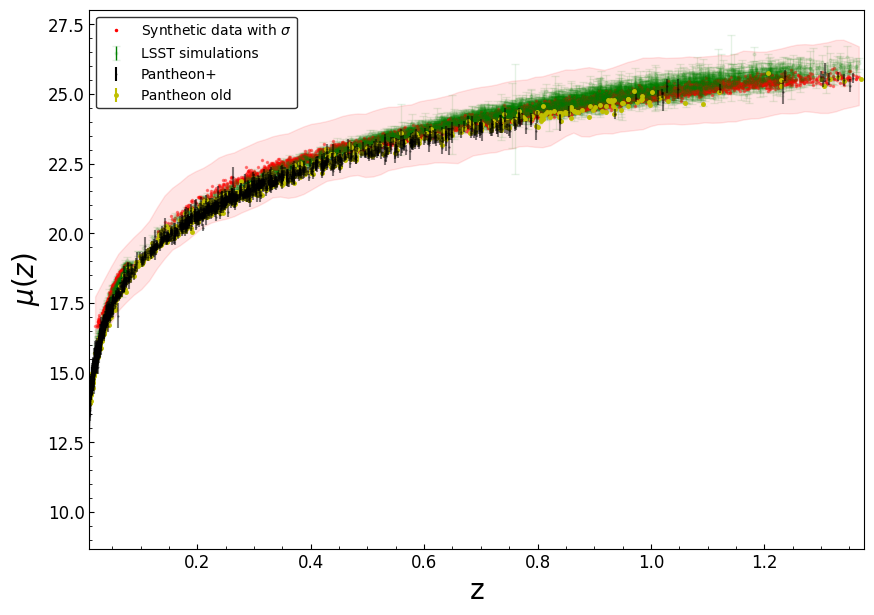

In [16]:
f, a2 = plt.subplots(figsize=(10, 7), dpi=100)

sigma = np.sqrt(std_mc_dropout[:, 0]**2 + std_mc_dropout[:, 1]**2+ prediction_mc_dropout[:,1]**2);

a2.errorbar(df_data['zCMB'], df_data['MU']-19, df_data['errors'], fmt='g.', markersize=4, color='g', 
            capsize=3, elinewidth=1,alpha=0.1, label='LSST simulations')

# a2.plot(zmodel, np.array(flcdm)-19, label='$\Lambda CDM$', c='b', linewidth=4, alpha=1.0, zorder=1);

a2.plot(z_or, prediction_mc_dropout[:,0]-19,'.',c='r',alpha=0.4, markersize=3,label='Synthetic data with $\sigma$',
        zorder=2);

a2.errorbar(df['zHD'], df['m_b_corr'], df['errors'], fmt='k.', markersize=1, label='Pantheon+', alpha=0.5, 
           zorder=4)

a2.errorbar(df1['zcmb'], df1['mb'], df1['errors'], fmt='y.', markersize=5, label='Pantheon old', alpha=1,
           zorder=3)




smoothed_lower = get_smoothed_curve(z_or, prediction_mc_dropout[:,0]-19, sigma, curve_type='lower');

smoothed_upper = get_smoothed_curve(z_or, prediction_mc_dropout[:,0]-19, sigma, curve_type='upper');

a2.fill_between(smoothed_lower[:, 0], smoothed_lower[:, 1], smoothed_upper[:, 1], color='red', alpha=0.1);


# plt.xlabel('Redshift')
# plt.ylabel('$H(z)$')
plt.ylabel("$\mu(z)$", fontsize=20);
plt.xlabel("z", fontsize=20);
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);
plt.minorticks_on()
a2.tick_params(axis='both', direction="in", which='minor', labelsize=15)
a2.tick_params(axis='both', direction="in", which='major', labelsize=12)

plt.xlim(zmin-0.01,zmax+0.01)
# plt.ylim(34, 47)

# plt.legend(loc='best')
legend = plt.legend(loc='upper left', edgecolor='black');
for lh in legend.legendHandles: 
    lh.set_alpha(1)

# legend.get_frame().set_facecolor((0, 0, 1, 0.1))
# plt.show()
# plt.tight_layout();

### ToDo: Check the constant to sum

For lsst_large with LCDM:

- Om: 0.3163 +/- 0.0049
- Obh2: 0.0220 +/- 0.0005
- h: 0.6967 +/- 0.1732
- -2756.3249 +/- 0.2767

For CPL:

- Om: 0.3297 +/- 0.0700
- Obh2: 0.0220 +/- 0.0004
- h: 0.7125 +/- 0.1585
- w: -1.0168 +/- 0.0679
- wa: -0.4305 +/- 0.8789
- logz: -2759.0397 +/- 0.3680

For PEDE

- Om: 0.3929 +/- 0.0638
- Obh2: 0.0220 +/- 0.0005
- h: 0.6875 +/- 0.1718
- Ode: 0.7132 +/- 0.1153
- logz: -2756.8247 +/- 0.2704

/tmp/ipykernel_73952/390522147.py:51: RuntimeWarning: divide by zero encountered in log10
  return 5 * np.log10(dL) + 25
/tmp/ipykernel_73952/390522147.py:104: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in legend.legendHandles:


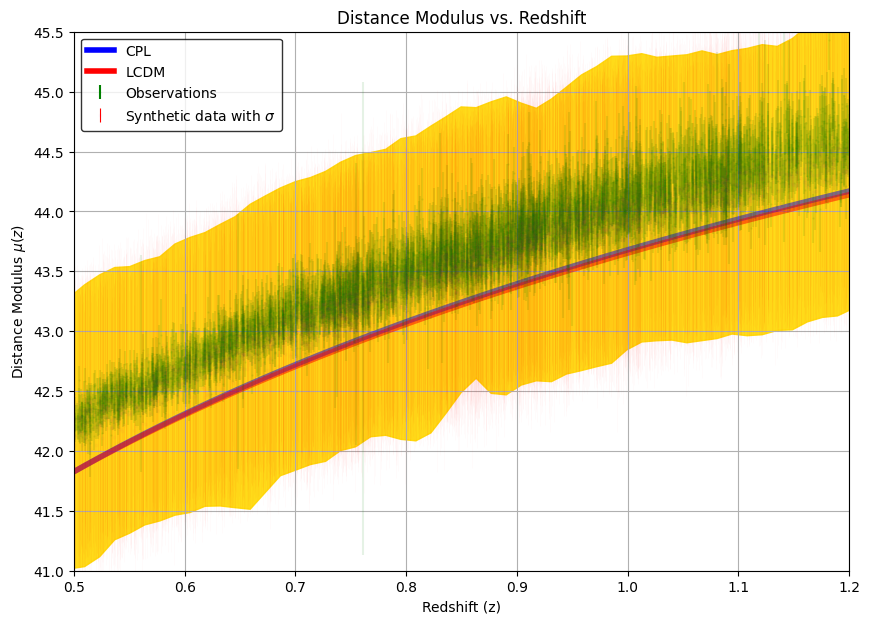

In [17]:
# Functions for PEDE model
def H_z_PEDE(z, H0, Omega_m0, Omega_DE0):
    term1 = Omega_m0 * (1 + z)**3
    term2 = Omega_DE0 * (1 - np.tanh(np.log10(1 + z)))
    return H0 * np.sqrt(term1 + term2)

# Functions for CPL model
def w_CPL(z, w0, wa):
    return w0 + wa * z / (1 + z)

def H_z_CPL(z, H0, Omega_m0, Omega_DE0, w0, wa):
    term1 = Omega_m0 * (1 + z)**3
    term2 = Omega_DE0 * (1 + z)**(3 * (1 + w_CPL(z, w0, wa)))
    return H0 * np.sqrt(term1 + term2)

# Functions for wCDM model
def H_z_wCDM(z, H0, Omega_m0, Omega_DE0, w):
    term1 = Omega_m0 * (1 + z)**3
    term2 = Omega_DE0 * (1 + z)**(3 * (1 + w))
    return H0 * np.sqrt(term1 + term2)

def luminosity_distance(z, model='PEDE'):
    # Parameters
    H0 = 70  # Hubble constant in km/s/Mpc
    Omega_m0 = 0.3  # Example value for matter density today
    Omega_DE0 = 0.7  # Example value for dark energy density today
    w0 = -1.0  # Example value for w0 in CPL model
    wa = 0.0  # Example value for wa in CPL model
    w = -0.9  # Example value for w in wCDM model
    if model == 'PEDE':
        Omega_m0 = 0.3929
        Omega_DE0 = 0.7132
        H0 = 0.6875 * 100
        integral, _ = quad(lambda z_prime: 1/H_z_PEDE(z_prime, H0, Omega_m0, Omega_DE0), 0, z)
    elif model == 'CPL':
        Omega_m0 = 0.3297
        H0 = 0.7125 * 100
        w0 = -1.0168
        wa = -0.4305
        integral, _ = quad(lambda z_prime: 1/H_z_CPL(z_prime, H0, Omega_m0, Omega_DE0, w0, wa), 0, z)
    elif model == 'LCDM':
        Omega_m0 = 0.3163
        H0 = 0.6967 * 100
        w0 = -1.0
        wa = 0.0
        integral, _ = quad(lambda z_prime: 1/H_z_wCDM(z_prime, H0, Omega_m0, Omega_DE0, w), 0, z)
    return (1 + z) * integral

def mu(z, model='PEDE'):
    dL = luminosity_distance(z, model)
    return 5 * np.log10(dL) + 25

# Parameters
# H0 = 70  # Hubble constant in km/s/Mpc
# Omega_m0 = 0.3  # Example value for matter density today
# Omega_DE0 = 0.7  # Example value for dark energy density today
# w0 = -1.0  # Example value for w0 in CPL model
# wa = 0.0  # Example value for wa in CPL model
# w = -0.9  # Example value for w in wCDM model

# Create an array of redshift values
z_values = np.linspace(0, 1.4, 100)
mu_PEDE_values = [mu(z, model='PEDE')+27 for z in z_values]

mu_CPL_values = [mu(z, model='CPL')+27 for z in z_values]

mu_LCDM_values = [mu(z, model='LCDM')+27 for z in z_values]




# Plotting
# plt.figure(figsize=(10, 7), dpi=100)
# plt.figure(figsize=(5, 4), dpi=100)
sigma = np.sqrt(std_mc_dropout[:, 0]**2 + std_mc_dropout[:, 1]**2+ prediction_mc_dropout[:,1]**2)



f, a2 = plt.subplots(figsize=(10, 7), dpi=100)

# Plotting
# plt.figure(figsize=(10, 7), dpi=100)
# a2.plot(z_values, mu_PEDE_values, label='PEDE')
a2.plot(z_values, mu_CPL_values, label='CPL', c='blue', linewidth=4, alpha=0.5)
a2.plot(z_values, mu_LCDM_values, label='LCDM', c='red', linewidth=4, alpha=0.5)

# plt.scatter(scalerz.inverse_transform(zz), yy, color='k', label='Original cosmic chronometers')
# plt.plot(zmodel, flcdm, label='$\Lambda CDM$', c='b')
a2.errorbar(df_data['zCMB'], df_data['MU'], df_data['errors'], fmt='g.', markersize=1, alpha=0.1, label='Observations')
a2.errorbar(z_or, prediction_mc_dropout[:,0], yerr=sigma, markersize=2, fmt='o', 
             ecolor='r', capthick=2, elinewidth=0.8, alpha=0.015, c='m',
             label='Synthetic data with $\sigma$')



smoothed_lower = get_smoothed_curve(z_or, prediction_mc_dropout[:,0], sigma, curve_type='lower');

smoothed_upper = get_smoothed_curve(z_or, prediction_mc_dropout[:,0], sigma, curve_type='upper');

a2.fill_between(smoothed_lower[:, 0], smoothed_lower[:, 1], smoothed_upper[:, 1], color='gold', alpha=0.9);


legend = plt.legend(loc='upper left', edgecolor='black');
for lh in legend.legendHandles: 
    lh.set_alpha(1)
    
plt.xlabel('Redshift (z)')
plt.ylabel('Distance Modulus $\mu(z)$')
plt.title('Distance Modulus vs. Redshift')
# plt.legend()
plt.xlim(0.5,1.2)
plt.ylim(41,45.5)
plt.grid(True)
plt.show()


/tmp/ipykernel_73952/2937628887.py:51: RuntimeWarning: divide by zero encountered in log10
  return 5 * np.log10(dL) + 25
/tmp/ipykernel_73952/2937628887.py:104: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in legend.legendHandles:


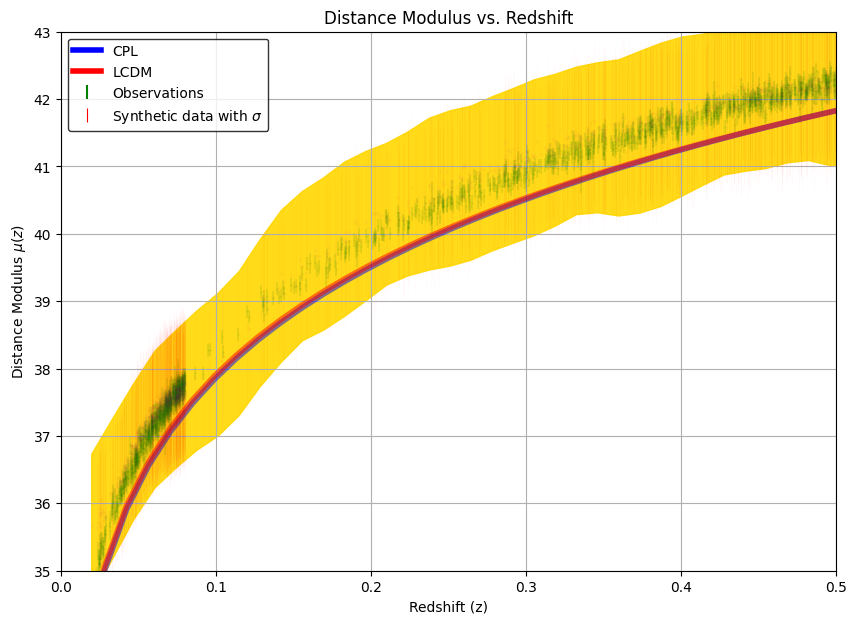

In [18]:
# Functions for PEDE model
def H_z_PEDE(z, H0, Omega_m0, Omega_DE0):
    term1 = Omega_m0 * (1 + z)**3
    term2 = Omega_DE0 * (1 - np.tanh(np.log10(1 + z)))
    return H0 * np.sqrt(term1 + term2)

# Functions for CPL model
def w_CPL(z, w0, wa):
    return w0 + wa * z / (1 + z)

def H_z_CPL(z, H0, Omega_m0, Omega_DE0, w0, wa):
    term1 = Omega_m0 * (1 + z)**3
    term2 = Omega_DE0 * (1 + z)**(3 * (1 + w_CPL(z, w0, wa)))
    return H0 * np.sqrt(term1 + term2)

# Functions for wCDM model
def H_z_wCDM(z, H0, Omega_m0, Omega_DE0, w):
    term1 = Omega_m0 * (1 + z)**3
    term2 = Omega_DE0 * (1 + z)**(3 * (1 + w))
    return H0 * np.sqrt(term1 + term2)

def luminosity_distance(z, model='PEDE'):
    # Parameters
    H0 = 70  # Hubble constant in km/s/Mpc
    Omega_m0 = 0.3  # Example value for matter density today
    Omega_DE0 = 0.7  # Example value for dark energy density today
    w0 = -1.0  # Example value for w0 in CPL model
    wa = 0.0  # Example value for wa in CPL model
    w = -0.9  # Example value for w in wCDM model
    if model == 'PEDE':
        Omega_m0 = 0.3929
        Omega_DE0 = 0.7132
        H0 = 0.6875 * 100
        integral, _ = quad(lambda z_prime: 1/H_z_PEDE(z_prime, H0, Omega_m0, Omega_DE0), 0, z)
    elif model == 'CPL':
        Omega_m0 = 0.3297
        H0 = 0.7125 * 100
        w0 = -1.0168
        wa = -0.4305
        integral, _ = quad(lambda z_prime: 1/H_z_CPL(z_prime, H0, Omega_m0, Omega_DE0, w0, wa), 0, z)
    elif model == 'LCDM':
        Omega_m0 = 0.3163
        H0 = 0.6967 * 100
        w0 = -1.0
        wa = 0.0
        integral, _ = quad(lambda z_prime: 1/H_z_wCDM(z_prime, H0, Omega_m0, Omega_DE0, w), 0, z)
    return (1 + z) * integral

def mu(z, model='PEDE'):
    dL = luminosity_distance(z, model)
    return 5 * np.log10(dL) + 25

# Parameters
# H0 = 70  # Hubble constant in km/s/Mpc
# Omega_m0 = 0.3  # Example value for matter density today
# Omega_DE0 = 0.7  # Example value for dark energy density today
# w0 = -1.0  # Example value for w0 in CPL model
# wa = 0.0  # Example value for wa in CPL model
# w = -0.9  # Example value for w in wCDM model

# Create an array of redshift values
z_values = np.linspace(0, 1.4, 100)
mu_PEDE_values = [mu(z, model='PEDE')+27 for z in z_values]

mu_CPL_values = [mu(z, model='CPL')+27 for z in z_values]

mu_LCDM_values = [mu(z, model='LCDM')+27 for z in z_values]




# Plotting
# plt.figure(figsize=(10, 7), dpi=100)
# plt.figure(figsize=(5, 4), dpi=100)
sigma = np.sqrt(std_mc_dropout[:, 0]**2 + std_mc_dropout[:, 1]**2+ prediction_mc_dropout[:,1]**2)



f, a2 = plt.subplots(figsize=(10, 7), dpi=100)

# Plotting
# plt.figure(figsize=(10, 7), dpi=100)
# a2.plot(z_values, mu_PEDE_values, label='PEDE')
a2.plot(z_values, mu_CPL_values, label='CPL', c='blue', linewidth=4, alpha=0.5)
a2.plot(z_values, mu_LCDM_values, label='LCDM', c='red', linewidth=4, alpha=0.5)

# plt.scatter(scalerz.inverse_transform(zz), yy, color='k', label='Original cosmic chronometers')
# plt.plot(zmodel, flcdm, label='$\Lambda CDM$', c='b')
a2.errorbar(df_data['zCMB'], df_data['MU'], df_data['errors'], fmt='g.', markersize=1, alpha=0.1, label='Observations')
a2.errorbar(z_or, prediction_mc_dropout[:,0], yerr=sigma, markersize=2, fmt='o', 
             ecolor='r', capthick=2, elinewidth=0.8, alpha=0.015, c='m',
             label='Synthetic data with $\sigma$')



smoothed_lower = get_smoothed_curve(z_or, prediction_mc_dropout[:,0], sigma, curve_type='lower');

smoothed_upper = get_smoothed_curve(z_or, prediction_mc_dropout[:,0], sigma, curve_type='upper');

a2.fill_between(smoothed_lower[:, 0], smoothed_lower[:, 1], smoothed_upper[:, 1], color='gold', alpha=0.9);


legend = plt.legend(loc='upper left', edgecolor='black');
for lh in legend.legendHandles: 
    lh.set_alpha(1)
    
plt.xlabel('Redshift (z)')
plt.ylabel('Distance Modulus $\mu(z)$')
plt.title('Distance Modulus vs. Redshift')
# plt.legend()
plt.xlim(0.0,0.5)
plt.ylim(35,43)
plt.grid(True)
plt.show()


/tmp/ipykernel_73952/894000771.py:51: RuntimeWarning: divide by zero encountered in log10
  return 5 * np.log10(dL) + 25
/tmp/ipykernel_73952/894000771.py:84: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in legend.legendHandles:


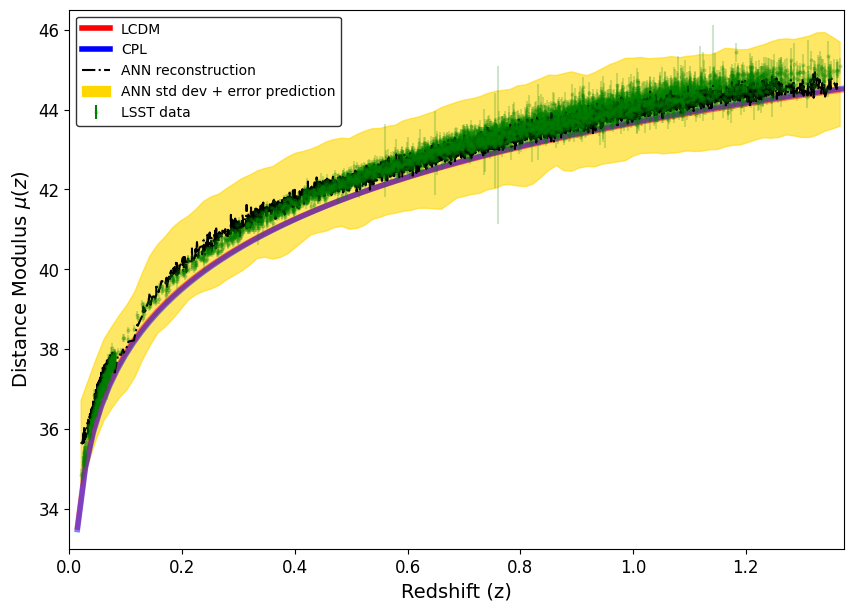

In [19]:
# Functions for PEDE model
def H_z_PEDE(z, H0, Omega_m0, Omega_DE0):
    term1 = Omega_m0 * (1 + z)**3
    term2 = Omega_DE0 * (1 - np.tanh(np.log10(1 + z)))
    return H0 * np.sqrt(term1 + term2)

# Functions for CPL model
def w_CPL(z, w0, wa):
    return w0 + wa * z / (1 + z)

def H_z_CPL(z, H0, Omega_m0, Omega_DE0, w0, wa):
    term1 = Omega_m0 * (1 + z)**3
    term2 = Omega_DE0 * (1 + z)**(3 * (1 + w_CPL(z, w0, wa)))
    return H0 * np.sqrt(term1 + term2)

# Functions for wCDM model
def H_z_wCDM(z, H0, Omega_m0, Omega_DE0, w):
    term1 = Omega_m0 * (1 + z)**3
    term2 = Omega_DE0 * (1 + z)**(3 * (1 + w))
    return H0 * np.sqrt(term1 + term2)

def luminosity_distance(z, model='PEDE'):
    # Parameters
    H0 = 70  # Hubble constant in km/s/Mpc
    Omega_m0 = 0.3  # Example value for matter density today
    Omega_DE0 = 0.7  # Example value for dark energy density today
    w0 = -1.0  # Example value for w0 in CPL model
    wa = 0.0  # Example value for wa in CPL model
    w = -0.9  # Example value for w in wCDM model
    if model == 'PEDE':
        Omega_m0 = 0.3929
        Omega_DE0 = 0.7132
        H0 = 0.6875 * 100
        integral, _ = quad(lambda z_prime: 1/H_z_PEDE(z_prime, H0, Omega_m0, Omega_DE0), 0, z)
    elif model == 'CPL':
        Omega_m0 = 0.3297
        H0 = 0.7125 * 100
        w0 = -1.0168
        wa = -0.4305
        integral, _ = quad(lambda z_prime: 1/H_z_CPL(z_prime, H0, Omega_m0, Omega_DE0, w0, wa), 0, z)
    elif model == 'LCDM':
        Omega_m0 = 0.3163
        H0 = 0.6967 * 100
        w0 = -1.0
        wa = 0.0
        integral, _ = quad(lambda z_prime: 1/H_z_wCDM(z_prime, H0, Omega_m0, Omega_DE0, w), 0, z)
    return (1 + z) * integral

def mu(z, model='PEDE'):
    dL = luminosity_distance(z, model)
    return 5 * np.log10(dL) + 25

f, a2 = plt.subplots(figsize=(10, 7), dpi=100)
# Create an array of redshift values
z_values = np.linspace(0, 1.4, 100)
# mu_PEDE_values = [mu(z, model='PEDE')+27 for z in z_values]

mu_CPL_values = [mu(z, model='CPL')+27 for z in z_values]

mu_LCDM_values = [mu(z, model='LCDM')+27 for z in z_values]

sigma = np.sqrt(std_mc_dropout[:, 0]**2 + std_mc_dropout[:, 1]**2+ prediction_mc_dropout[:,1]**2)




# Plotting
# plt.figure(figsize=(10, 7), dpi=100)
# a2.plot(z_values, mu_PEDE_values, label='PEDE')
a2.plot(z_values, mu_LCDM_values, label='LCDM', c='red', linewidth=4, alpha=0.5)
a2.plot(z_values, mu_CPL_values, label='CPL', c='blue', linewidth=4, alpha=0.5)
a2.errorbar(df_data['zCMB'], df_data['MU'], df_data['errors'], fmt='go', markersize=2, alpha=0.2, label='LSST data')
# a2.scatter(df_data['zCMB'], df_data['MU'], c='g', alpha=0.5)

smoothed_lower = get_smoothed_curve(z_or, prediction_mc_dropout[:,0], sigma, curve_type='lower');
smoothed_upper = get_smoothed_curve(z_or, prediction_mc_dropout[:,0], sigma, curve_type='upper');

a2.plot(z_or, prediction_mc_dropout[:,0], c='k', linestyle='-.',label='ANN reconstruction')
a2.fill_between(smoothed_lower[:, 0], smoothed_lower[:, 1], smoothed_upper[:, 1], color='gold', alpha=0.6, label='ANN std dev + error prediction');


legend = plt.legend(loc='upper left', edgecolor='black');

for lh in legend.legendHandles: 
    lh.set_alpha(1)
    
plt.xlim(0.0,1.375)
plt.ylim(33,46.5)
# plt.grid(True)

plt.xlabel('Redshift (z)', fontsize=14)
plt.ylabel('Distance Modulus $\mu(z)$', fontsize=14)
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)

plt.savefig('reconstruction_models.png')

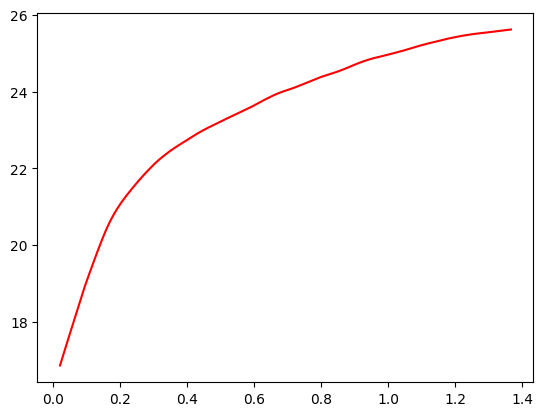

In [20]:
f_interpolated = interp1d(z_or.flatten(), prediction_mc_dropout[:,0]-19, kind='linear')
#f_interpolated = interp1d(z_or.flatten(), prediction_mc_dropout[:,0]-19, kind='linear', fill_value="extrapolate")

# Create finer x-values for smoother plotting
z_fine = np.linspace(min(z_or), max(z_or), 1000)
y_fine_interpolated = f_interpolated(z_fine)

# Apply lowess smoothing
smoothed = lowess(y_fine_interpolated.flatten(), z_fine.flatten(), frac=0.1)
plt.plot(smoothed[:, 0], smoothed[:, 1], 'r-', label="Best-fit (interp1d + lowess)")

/tmp/ipykernel_73952/1690474888.py:51: RuntimeWarning: divide by zero encountered in log10
  return 5 * np.log10(dL) + 25
/tmp/ipykernel_73952/1690474888.py:108: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in legend.legendHandles:


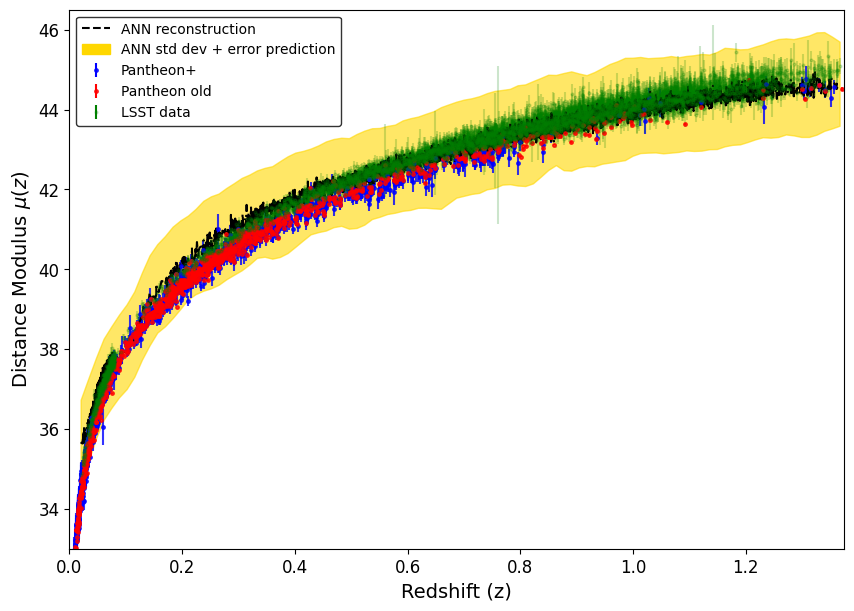

In [21]:
# Functions for PEDE model
def H_z_PEDE(z, H0, Omega_m0, Omega_DE0):
    term1 = Omega_m0 * (1 + z)**3
    term2 = Omega_DE0 * (1 - np.tanh(np.log10(1 + z)))
    return H0 * np.sqrt(term1 + term2)

# Functions for CPL model
def w_CPL(z, w0, wa):
    return w0 + wa * z / (1 + z)

def H_z_CPL(z, H0, Omega_m0, Omega_DE0, w0, wa):
    term1 = Omega_m0 * (1 + z)**3
    term2 = Omega_DE0 * (1 + z)**(3 * (1 + w_CPL(z, w0, wa)))
    return H0 * np.sqrt(term1 + term2)

# Functions for wCDM model
def H_z_wCDM(z, H0, Omega_m0, Omega_DE0, w):
    term1 = Omega_m0 * (1 + z)**3
    term2 = Omega_DE0 * (1 + z)**(3 * (1 + w))
    return H0 * np.sqrt(term1 + term2)

def luminosity_distance(z, model='PEDE'):
    # Parameters
    H0 = 70  # Hubble constant in km/s/Mpc
    Omega_m0 = 0.3  # Example value for matter density today
    Omega_DE0 = 0.7  # Example value for dark energy density today
    w0 = -1.0  # Example value for w0 in CPL model
    wa = 0.0  # Example value for wa in CPL model
    w = -0.9  # Example value for w in wCDM model
    if model == 'PEDE':
        Omega_m0 = 0.3929
        Omega_DE0 = 0.7132
        H0 = 0.6875 * 100
        integral, _ = quad(lambda z_prime: 1/H_z_PEDE(z_prime, H0, Omega_m0, Omega_DE0), 0, z)
    elif model == 'CPL':
        Omega_m0 = 0.3297
        H0 = 0.7125 * 100
        w0 = -1.0168
        wa = -0.4305
        integral, _ = quad(lambda z_prime: 1/H_z_CPL(z_prime, H0, Omega_m0, Omega_DE0, w0, wa), 0, z)
    elif model == 'LCDM':
        Omega_m0 = 0.3163
        H0 = 0.6967 * 100
        w0 = -1.0
        wa = 0.0
        integral, _ = quad(lambda z_prime: 1/H_z_wCDM(z_prime, H0, Omega_m0, Omega_DE0, w), 0, z)
    return (1 + z) * integral

def mu(z, model='PEDE'):
    dL = luminosity_distance(z, model)
    return 5 * np.log10(dL) + 25

# Parameters
# H0 = 70  # Hubble constant in km/s/Mpc
# Omega_m0 = 0.3  # Example value for matter density today
# Omega_DE0 = 0.7  # Example value for dark energy density today
# w0 = -1.0  # Example value for w0 in CPL model
# wa = 0.0  # Example value for wa in CPL model
# w = -0.9  # Example value for w in wCDM model

# Create an array of redshift values
z_values = np.linspace(0, 1.4, 100)
# mu_PEDE_values = [mu(z, model='PEDE')+27 for z in z_values]

mu_CPL_values = [mu(z, model='CPL')+27 for z in z_values]

mu_LCDM_values = [mu(z, model='LCDM')+27 for z in z_values]




# Plotting
# plt.figure(figsize=(10, 7), dpi=100)
# plt.figure(figsize=(5, 4), dpi=100)
sigma = np.sqrt(std_mc_dropout[:, 0]**2 + std_mc_dropout[:, 1]**2+ prediction_mc_dropout[:,1]**2)



f, a2 = plt.subplots(figsize=(10, 7), dpi=100)

# Plotting
# plt.figure(figsize=(10, 7), dpi=100)
# a2.plot(z_values, mu_PEDE_values, label='PEDE')
plt.errorbar(df['zHD'], df['m_b_corr']+19, df['errors'], fmt='b.', markersize=5, label='Pantheon+', alpha=0.8)
plt.errorbar(df1['zcmb'], df1['mb']+19, df1['errors'], fmt='r.', markersize=5, label='Pantheon old', alpha=0.8)

# plt.scatter(scalerz.inverse_transform(zz), yy, color='k', label='Original cosmic chronometers')
# plt.plot(zmodel, flcdm, label='$\Lambda CDM$', c='b')
a2.errorbar(df_data['zCMB'], df_data['MU'], df_data['errors'], fmt='go', markersize=2, alpha=0.2, label='LSST data')
# a2.scatter(df_data['zCMB'], df_data['MU'], c='g', alpha=0.5, label='LSST data')
# a2.errorbar(z_or, prediction_mc_dropout[:,0], yerr=sigma, markersize=2, fmt='.-', 
#              ecolor='k', capthick=2, elinewidth=1, alpha=0.015, c='k',
#              label='Neural reconstruction$')

a2.plot(z_or, prediction_mc_dropout[:,0], c='k', linestyle='-.')



smoothed_lower = get_smoothed_curve(z_or, prediction_mc_dropout[:,0], sigma, curve_type='lower');

smoothed_upper = get_smoothed_curve(z_or, prediction_mc_dropout[:,0], sigma, curve_type='upper');

a2.plot(smoothed[15:, 0]+25, smoothed[15:, 1]+25, c='black',linestyle='--',alpha=0.99,markersize=5,label='ANN reconstruction')
a2.fill_between(smoothed_lower[:, 0], smoothed_lower[:, 1], smoothed_upper[:, 1], color='gold', alpha=0.6, label='ANN std dev + error prediction');


legend = plt.legend(loc='upper left', edgecolor='black');
for lh in legend.legendHandles: 
    lh.set_alpha(1)
    
plt.xlabel('Redshift (z)', fontsize=14)
plt.ylabel('Distance Modulus $\mu(z)$', fontsize=14)
# plt.title('Distance Modulus vs. Redshift')
# plt.legend()
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)
plt.xlim(0.0,1.375)
plt.ylim(33,46.5)
# plt.grid(True)

plt.savefig('reconstruction_compilations.png')

## Residuals

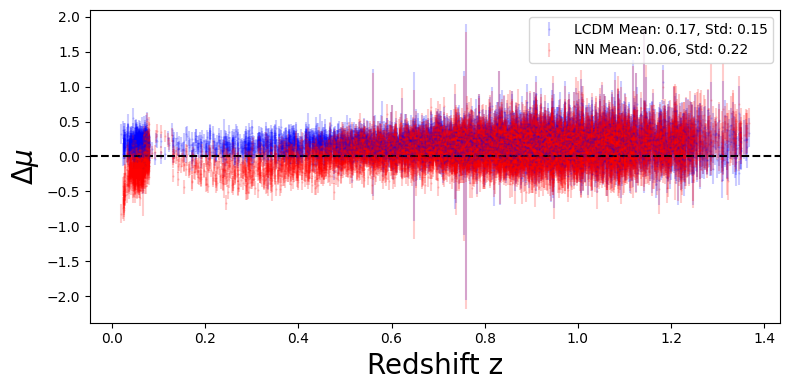

In [22]:
flcdm_1d = np.array([item[0]for item in flcdm])
# flcdm = flcdm_1d
# Compute residuals
residuals_lcdm = df_data['MU'].values - (flcdm_1d)
residuals_neural = df_data['MU'].values - prediction_mc_dropout[:,0]

# Create a figure and set up a gridspec for the main plot and residuals
plt.figure(figsize=(8,4))
# Residual plot
plt.errorbar(df_data['zCMB'], residuals_lcdm, df_data['errors'],
             fmt='b.', markersize=1, alpha=0.2, label=f'LCDM Mean: {np.mean(residuals_lcdm):.2f}, Std: {np.std(residuals_lcdm):.2f}')
plt.errorbar(df_data['zCMB'], residuals_neural, df_data['errors'],
             fmt='r.', markersize=1, alpha=0.2, label=f'NN Mean: {np.mean(residuals_neural):.2f}, Std: {np.std(residuals_neural):.2f}')
plt.axhline(0, color='black', linestyle='--')
plt.xlabel("Redshift z", fontsize=20)
plt.ylabel("$\\Delta \\mu$", fontsize=20)
plt.legend()
plt.grid(False)
#sns.despine(ax=ax_resid)

plt.tight_layout()


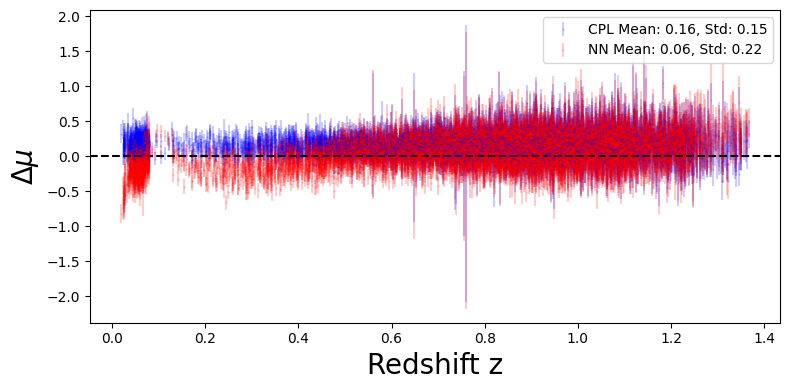

In [23]:
fcpl_1d = np.array([item[0]for item in fcpl])
# Compute residuals
residuals_cpl = df_data['MU'].values - (fcpl_1d)
residuals_neural = df_data['MU'].values - prediction_mc_dropout[:,0]

# Create a figure and set up a gridspec for the main plot and residuals
plt.figure(figsize=(8,4))
# Residual plot
plt.errorbar(df_data['zCMB'], residuals_cpl, df_data['errors'],
             fmt='b.', markersize=1, alpha=0.2, label=f'CPL Mean: {np.mean(residuals_cpl):.2f}, Std: {np.std(residuals_cpl):.2f}')
plt.errorbar(df_data['zCMB'], residuals_neural, df_data['errors'],
             fmt='r.', markersize=1, alpha=0.2, label=f'NN Mean: {np.mean(residuals_neural):.2f}, Std: {np.std(residuals_neural):.2f}')
plt.axhline(0, color='black', linestyle='--')
plt.xlabel("Redshift z", fontsize=20)
plt.ylabel("$\\Delta \\mu$", fontsize=20)
plt.legend()
plt.grid(False)
#sns.despine(ax=ax_resid)

plt.tight_layout()


## LSST

In [24]:
data_folder = 'Data_SNIa_LSST/larger/'
df_data = pd.read_csv(data_folder+'hubble_diagram.txt', skiprows=5, sep=' ')
df_data['errors'] = df_data['MUERR'].values+df_data['MUERR_SYS'].values

df_data = df_data[['zCMB', 'MU', 'errors']]
z_or = df_data[['zCMB']].values
y = df_data[['MU', 'errors']].values
scalerz = StandardScaler()
scalerz.fit(z_or.reshape(-1,1))
# apply transform
z = scalerz.transform(z_or.reshape(-1,1))
# Generate test data
# test_batch_size = 500
test_batch_size = len(z)
x_test = z

mc_dropout_num = 100 # Run Dropout 100 times
predictions = np.zeros((mc_dropout_num, test_batch_size, 2))
uncertainty = np.zeros((mc_dropout_num, test_batch_size, 1))
for i in range(mc_dropout_num):
    predictions[i] = model.predict(scalerz.transform(z_or.reshape(-1,1)))
#     predictions[i] = model.predict(scalerz.transform(x_test.reshape(-1,1)))
    
# get mean results and its varience
prediction_mc_dropout = np.mean(predictions, axis=0)
std_mc_dropout = np.std(predictions, axis=0)


181/181 [==============================] - 0s 2ms/step


In [25]:
mse_lcdm = mean_squared_error(np.sort(prediction_mc_dropout[:,0]), flcdm)
mse_cpl = mean_squared_error(fcpl, np.sort(prediction_mc_dropout[:,0]))
mse_lcdm, mse_cpl

(0.020509409519810843, 0.018809237587478402)

In [26]:
# mean_squared_error, euclidean_distances, median_absolute_error
mse_lcdm = mean_squared_error(df_data['MU'].values, flcdm)
mse_cpl = mean_squared_error(df_data['MU'].values, fcpl)
mse_neural = mean_squared_error(df_data['MU'].values, np.sort(prediction_mc_dropout[:,0]))
mse_lcdm, mse_cpl, mse_neural

(0.05164288391890468, 0.047074969080691725, 0.03796966313153921)